Takes an AOI and enumerates pairs of SLCs for interferograms.

In [2]:
import geopandas as gpd
import yaml
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import asf_search as asf
from datetime import timedelta
import datetime
from dateparser import parse
import concurrent.futures
import hyp3_sdk
import numpy as np
from data_model import enumParams

# Setup

In [3]:
YAML_FILE = 'enum_configs/palos_verdes_ca_2024-07.yml' #'enumeration_parameters.yml'
PARAMS = enumParams.from_yaml(YAML_FILE)

In [4]:
PARAMS.__dict__

{'temporal_baseline_days': [0, 180, 365],
 'n_secondaries_per_reference': [3, 1, 1],
 'aoi_name': 'palos_verdes_ca',
 'n_seeds': 3,
 'track_numbers': None,
 'data_directory': 'out',
 'date_of_enum': datetime.date(2024, 7, 30),
 'stack_dir': PosixPath('out/palos_verdes_ca__tb_0-180-365__neigh_3-1-1/stack'),
 'enum_dir': PosixPath('out/palos_verdes_ca__tb_0-180-365__neigh_3-1-1/enum'),
 'yaml_path': PosixPath('out/palos_verdes_ca__tb_0-180-365__neigh_3-1-1/enum_params_2024-07-30.yml'),
 'weather_model': 'hrrr',
 'month_constraints': None,
 'exclusive_month_constraints': False,
 'aoi_geojson_path': PosixPath('AOIs/palos_verdes_ca.geojson'),
 'valid_date_ranges': [[datetime.datetime(2023, 2, 1, 0, 0, tzinfo=datetime.timezone.utc),
   datetime.datetime(2024, 8, 1, 0, 0, tzinfo=datetime.timezone.utc)]],
 'enum_parent_dir': PosixPath('out/palos_verdes_ca__tb_0-180-365__neigh_3-1-1'),
 'yaml_path_record': PosixPath('enum_configs/palos_verdes_ca_2024-07.yml')}

# Read enumeration data

# list(PARAMS.enum_dir.glob('*.geojson'))

In [5]:
dfs = [gpd.read_file(p) for p in tqdm(list(PARAMS.enum_dir.glob('*.geojson')))]
df_ifg = pd.concat(dfs, axis=0)
df_ifg.head()

100%|█| 3/3 [00:00<00:00, 20.03it/s


,reference,secondary,reference_date,secondary_date,frame_id,track_aoi_key,aoi_name,geometry
0,S1A_IW_SLC__1SDV_20240725T015015_20240725T0150...,S1A_IW_SLC__1SDV_20240713T015016_20240713T0150...,2024-07-25,2024-07-13,9848,track64,palos_verdes_ca,"POLYGON Z ((-118.74228 33.52202 0.00000, -118...."
1,S1A_IW_SLC__1SDV_20240725T015015_20240725T0150...,S1A_IW_SLC__1SDV_20240701T015016_20240701T0150...,2024-07-25,2024-07-01,9848,track64,palos_verdes_ca,"POLYGON Z ((-118.74228 33.52202 0.00000, -118...."
2,S1A_IW_SLC__1SDV_20240725T015015_20240725T0150...,S1A_IW_SLC__1SDV_20240619T015017_20240619T0150...,2024-07-25,2024-06-19,9848,track64,palos_verdes_ca,"POLYGON Z ((-118.74228 33.52202 0.00000, -118...."
3,S1A_IW_SLC__1SDV_20240713T015016_20240713T0150...,S1A_IW_SLC__1SDV_20240701T015016_20240701T0150...,2024-07-13,2024-07-01,9848,track64,palos_verdes_ca,"POLYGON Z ((-118.74228 33.52202 0.00000, -118...."
4,S1A_IW_SLC__1SDV_20240713T015016_20240713T0150...,S1A_IW_SLC__1SDV_20240619T015017_20240619T0150...,2024-07-13,2024-06-19,9848,track64,palos_verdes_ca,"POLYGON Z ((-118.74228 33.52202 0.00000, -118...."


In [6]:
df_ifg.shape

(413, 8)

Let's look at each group and its size (i.e. the number of IFGs)

In [7]:
df_count = df_ifg.groupby('track_aoi_key').count().reset_index(drop=False)
df_count['track'] = df_count['track_aoi_key'].map(lambda key: int(key.replace('track', '')))
df_count.sort_values(by='track', inplace=True)
df_count

,track_aoi_key,reference,secondary,reference_date,secondary_date,frame_id,aoi_name,geometry,track
1,track64,136,136,136,136,136,136,136,64
2,track71,142,142,142,142,142,142,142,71
0,track137,135,135,135,135,135,135,135,137


In [8]:
for k, row in df_count.iterrows():
    print(row['reference'])

136
142
135


# Filtering Jobs (Optional)

When first submitting jobs, you may just want to submit one track at a time. Easiest to filter on the dataframe with all the IFGs. That's what we will do. Below shows how to filter on a single "track_aoi_id".

In [9]:
df_ifg_submission = df_ifg.copy()

Can uncomment and figure out which track aois to use

In [10]:
# df_ifg_submission = df_ifg[df_ifg.track_aoi_key != 'track106'].reset_index(drop=True)
# df_ifg_submission.head()

In [11]:
from s1_frame_enumerator import get_global_gunw_footprints
import matplotlib.pyplot as plt
import contextily as cx

df_gunw_foot = get_global_gunw_footprints()

In [12]:
frames_enum = df_ifg_submission.frame_id.unique().tolist()
df_gunw_foot_sub = df_gunw_foot[df_gunw_foot.frame_id.isin(frames_enum)].reset_index(drop=True)

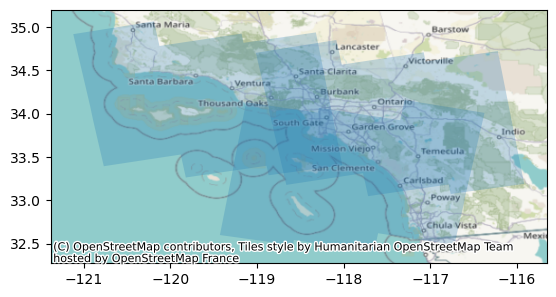

In [13]:
fig, ax = plt.subplots()
df_gunw_foot_sub.plot(ax=ax, alpha=.25)
cx.add_basemap(ax, crs=df_ifg_submission.crs.to_string())

In [14]:
df_ifg_submission.shape

(413, 8)

# Deduplication of IFGs CMR - Requires CMR Ingest - WIP

The deduplicaiton is based on this (and related) [thread](https://github.com/asfadmin/Discovery-asf_search/issues/296). Here is a sample.

In [15]:
import asf_search as asf

opts = asf.ASFSearchOptions(
    shortName='ARIA_S1_GUNW',
    asfFrame=14211, 
    temporalBaselineDays=12,
    start=parse('2024-03-16'),
    end=parse('2024-03-17T23:00:00')
)
scenes = asf.search(opts=opts)
print(len(scenes))
scenes[0].properties

1


{'centerLat': None,
 'centerLon': None,
 'stopTime': '2024-03-16T23:36:26Z',
 'fileID': 'S1-GUNW-A-R-091-tops-20240316_20240304-233600-00074W_00037S-PP-4b33-v3_0_1',
 'flightDirection': 'ascending',
 'pathNumber': 91,
 'processingLevel': None,
 'url': 'https://grfn.asf.alaska.edu/door/download/S1-GUNW-A-R-091-tops-20240316_20240304-233600-00074W_00037S-PP-4b33-v3_0_1.nc',
 'startTime': '2024-03-16T23:35:34Z',
 'sceneName': None,
 'browse': ['https://grfn-public-prod.asf.alaska.edu/S1-GUNW-A-R-091-tops-20240316_20240304-233600-00074W_00037S-PP-4b33-v3_0_1.png'],
 'platform': 'Sentinel-1A',
 'bytes': None,
 'md5sum': None,
 'frameNumber': 14211,
 'granuleType': None,
 'orbit': [53013, 52838],
 'polarization': 'VV',
 'processingDate': '2024-03-26T03:18:06Z',
 'sensor': None,
 'groupID': None,
 'pgeVersion': None,
 'perpendicularBaseline': 70.8606,
 'inputGranules': ['S1A_IW_SLC__1SDV_20240316T233534_20240316T233601_053013_066B21_474E',
  'S1A_IW_SLC__1SDV_20240316T233559_20240316T233626_0

In [16]:
def get_gunw_hits(record):

    frame_id = int(record['frame_id'])
    ref_date = parse(record['reference_date'])
    sec_date = parse(record['secondary_date'])
    
    start = ref_date - timedelta(days=1)
    end = ref_date + timedelta(days=1)
    tb_days = (ref_date - sec_date).days
    
    opts = asf.ASFSearchOptions(shortName='ARIA_S1_GUNW',
                                asfFrame=frame_id, 
                                start=start, 
                                end=end, 
                                temporalBaselineDays=[tb_days],
                                maxResults=3
                                )
    
    results = asf.search(opts=opts)
    return len(results)

In [17]:
submission_records = df_ifg_submission.to_dict('records')

# list(map(get_gunw_hits, tqdm(submission_records[:30])))

Make sure not to use more than 5 threads at a time as that will overload CMR server that handles such requests.

In [18]:
n = len(submission_records)
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    ifg_hits_cmr = list(tqdm(executor.map(get_gunw_hits, submission_records[:]), total=n))

100%|█| 413/413 [00:30<00:00, 13.69


In [20]:
# TODO: set to ifg_hits_cmr
print('Before dedup: ', df_ifg_submission.shape[0])
df_ifg_submission['cmr_hits'] = ifg_hits_cmr
if ifg_hits_cmr:
    df_ifg_submission = df_ifg_submission[df_ifg_submission['cmr_hits'] == 0].reset_index(drop=True)
print('After dedup: ', df_ifg_submission.shape[0])

Before dedup:  413
After dedup:  128


# Format Job Parameters

We format the dictionary of inputs for the interferograms (IFGs) into the format required by Hyp3 (just reformats into another dictionary).

In [21]:
# regenerate after deduplication
submission_records = df_ifg_submission.to_dict('records')
submission_records[0]

{'reference': 'S1A_IW_SLC__1SDV_20240725T015015_20240725T015045_054911_06B032_4901 S1A_IW_SLC__1SDV_20240725T015043_20240725T015111_054911_06B032_BAE5',
 'secondary': 'S1A_IW_SLC__1SDV_20240713T015016_20240713T015045_054736_06AA18_B737 S1A_IW_SLC__1SDV_20240713T015043_20240713T015111_054736_06AA18_41B9',
 'reference_date': '2024-07-25',
 'secondary_date': '2024-07-13',
 'frame_id': 9848,
 'track_aoi_key': 'track64',
 'aoi_name': 'palos_verdes_ca',
 'geometry': <POLYGON Z ((-118.742 33.522 0, -118.862 34.036 0, -118.858 34.036 0, -118.9...>,
 'cmr_hits': 0}

In [22]:
def generate_job_name(record):
    track_key = record['track_aoi_key']
    aoi_name = record['aoi_name']
    return f'{aoi_name}-{track_key}'

In [23]:
job_names = list(map(generate_job_name, submission_records))
job_names_unique = sorted(list(set(job_names)))
job_names_unique[:5]

['palos_verdes_ca-track137',
 'palos_verdes_ca-track64',
 'palos_verdes_ca-track71']

## Make sure to select the weather model

In [24]:
WEATHER_MODEL = PARAMS.weather_model
if WEATHER_MODEL is not None:
    WEATHER_MODEL = WEATHER_MODEL.upper()
WEATHER_MODEL

'HRRR'

In [25]:
df_us = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')
df_hrrr = df_us[~df_us.name.isin(['Hawaii'])].reset_index(drop=True)

intersection_conus = df_ifg.iloc[:100].geometry.unary_union.intersects(df_hrrr.geometry.unary_union)

if intersection_conus and (WEATHER_MODEL is None):
    raise ValueError('Should select HRRRR')

if (WEATHER_MODEL == 'HRRR') and not intersection_conus:
    raise ValueError('HRRR is not valid for GUNW')

In [26]:
job_parameters = [{'granules': record['reference'].split(' '),
                   'secondary_granules': record['secondary'].split(' '),
                   'frame_id': int(record['frame_id']),
                   'weather_model': WEATHER_MODEL,
                  } for record in submission_records]
# Weather model should not be supplied if None
[p.pop('weather_model') for p in job_parameters if p['weather_model'] is None]
job_parameters[:2]

[{'granules': ['S1A_IW_SLC__1SDV_20240725T015015_20240725T015045_054911_06B032_4901',
   'S1A_IW_SLC__1SDV_20240725T015043_20240725T015111_054911_06B032_BAE5'],
  'secondary_granules': ['S1A_IW_SLC__1SDV_20240713T015016_20240713T015045_054736_06AA18_B737',
   'S1A_IW_SLC__1SDV_20240713T015043_20240713T015111_054736_06AA18_41B9'],
  'frame_id': 9848,
  'weather_model': 'HRRR'},
 {'granules': ['S1A_IW_SLC__1SDV_20240725T015015_20240725T015045_054911_06B032_4901',
   'S1A_IW_SLC__1SDV_20240725T015043_20240725T015111_054911_06B032_BAE5'],
  'secondary_granules': ['S1A_IW_SLC__1SDV_20240701T015016_20240701T015046_054561_06A407_AEC9',
   'S1A_IW_SLC__1SDV_20240701T015044_20240701T015111_054561_06A407_B31D'],
  'frame_id': 9848,
  'weather_model': 'HRRR'}]

In [27]:
job_dicts = [{'name': job_name,
              # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
              'job_type': 'INSAR_ISCE',
              'job_parameters': parameters
             }
             for parameters, job_name in zip(job_parameters, job_names) ]
job_dicts[:2]

[{'name': 'palos_verdes_ca-track64',
  'job_type': 'INSAR_ISCE',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20240725T015015_20240725T015045_054911_06B032_4901',
    'S1A_IW_SLC__1SDV_20240725T015043_20240725T015111_054911_06B032_BAE5'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20240713T015016_20240713T015045_054736_06AA18_B737',
    'S1A_IW_SLC__1SDV_20240713T015043_20240713T015111_054736_06AA18_41B9'],
   'frame_id': 9848,
   'weather_model': 'HRRR'}},
 {'name': 'palos_verdes_ca-track64',
  'job_type': 'INSAR_ISCE',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20240725T015015_20240725T015045_054911_06B032_4901',
    'S1A_IW_SLC__1SDV_20240725T015043_20240725T015111_054911_06B032_BAE5'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20240701T015016_20240701T015046_054561_06A407_AEC9',
    'S1A_IW_SLC__1SDV_20240701T015044_20240701T015111_054561_06A407_B31D'],
   'frame_id': 9848,
   'weather_model': 'HRRR'}}]

# Submit Jobs to Hyp3

This is where we take the job dictionaries and submit them to Hyp3. Note, we have different AWS accounts associated to different API endpoints i.e. `hyp3-a19-jpl` and `hyp3-tibet-jpl` are different AWS accounts using the same workflow and are separated for accounting purposes.

In [ ]:
# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-a19-jpl.asf.alaska.edu', prompt=True)
# hyp3_isce = hyp3_sdk.HyP3('https://hyp3-tibet-jpl.asf.alaska.edu', prompt=True)


Can submit one test job.

In [27]:
# Uncomment to submit one test job.
# submitted_jobs = hyp3_isce.submit_prepared_jobs(job_dicts[:1])
# submitted_jobs[0].to_dict()

Grouping jobs by name

In [28]:
##### This is if you want to group batches and submit only one track at a time.

## jobs_by_group = list(map(lambda job_name: [j for j in job_dicts[:]
##                                            if j['name'] == job_name], tqdm(job_names_unique)))

Hyp3 requires us to submit 200 jobs at a time.

In [31]:
batches = [batch for batch in hyp3_sdk.util.chunk(job_dicts, 200)]
batches[0][0], len(batches[0]), len(batches)

({'name': 'conus_west_coast-track64_1',
  'job_type': 'INSAR_ISCE',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20240303T015016_20240303T015046_052811_066417_3CCA'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20240220T015016_20240220T015046_052636_065E1F_0823'],
   'frame_id': 9847,
   'weather_model': 'HRRR'}},
 200,
 489)

## Submitting the Jobs!

This is where you spend the money!!!

In [32]:
### Submit one batch
# hyp3_jobs_out = hyp3_isce.submit_prepared_jobs(batches[0])

### Submitting all the batches
## hyp3_jobs_out = [hyp3_isce.submit_prepared_jobs(batch) for batch in tqdm(batches)]

### or to submit certain batches
## hyp3_jobs_out = [hyp3_isce.submit_prepared_jobs(batches[k]) for k in tqdm(range(2, len(batches)))]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 489/489 [13:42<00:00,  1.68s/it]


# Check the status of submitted jobs

Check status; note that we use the `start` keyword argument. This massively optimizes search queries (you can use this information in the dynamoDB query).

Also, note that I put the job names as a comment so I can get them later should I want them.

In [9]:
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-a19-jpl.asf.alaska.edu')


In [17]:
JOB_NAMES_INSPECTION = job_names_unique[:] # ['tibet-track136', 'tibet-track33']
JOB_NAMES_INSPECTION

NameError: name 'job_names_unique' is not defined

In [23]:
now = datetime.datetime.now()
submit_time_approx = now - timedelta(hours=500)

In [28]:
jobs = hyp3_isce.find_jobs(start=datetime.datetime(2024, 3, 18), 
                           end=datetime.datetime(2024, 3, 21),
                           user_id='access_cloud_based_insar')
print(jobs)

97689 HyP3 Jobs: 32489 succeeded, 65200 failed, 0 running, 0 pending.


In [42]:
for job_name in JOB_NAMES_INSPECTION:
    jobs = hyp3_isce.find_jobs(name=job_name, start=submit_time_approx)
    print('#' * 10)
    print(job_name)
    print(jobs)

##########
conus_west_coast-track100
1485 HyP3 Jobs: 0 succeeded, 134 failed, 0 running, 1351 pending.
##########
conus_west_coast-track108
1173 HyP3 Jobs: 0 succeeded, 87 failed, 0 running, 1086 pending.
##########
conus_west_coast-track115
4160 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 4160 pending.
##########
conus_west_coast-track13
3064 HyP3 Jobs: 0 succeeded, 232 failed, 36 running, 2796 pending.
##########
conus_west_coast-track137
15275 HyP3 Jobs: 0 succeeded, 1357 failed, 15 running, 13903 pending.
##########
conus_west_coast-track144
7952 HyP3 Jobs: 0 succeeded, 0 failed, 53 running, 7899 pending.
##########
conus_west_coast-track144_1
9198 HyP3 Jobs: 0 succeeded, 843 failed, 0 running, 8355 pending.
##########
conus_west_coast-track166
2970 HyP3 Jobs: 0 succeeded, 278 failed, 0 running, 2692 pending.
##########
conus_west_coast-track166_1
5670 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 5670 pending.
##########
conus_west_coast-track173
7344 HyP3 Jobs: 0 succeeded, 151 f

# Failed jobs

Looked at failed jobs. Again, this will be cleaned up once we ingest into CMR.

In [30]:
now = datetime.datetime.now()
submit_time_approx = now - timedelta(hours=96)

In [31]:
JOB_NAME_INSPECTION = 'conus_west_coast-track35' # job_names_unique[0]
JOB_NAME_INSPECTION

'conus_west_coast-track35'

In [1]:
import hyp3_sdk
import datetime
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-a19-jpl.asf.alaska.edu')


In [27]:
jobs_failed = hyp3_isce.find_jobs(start=datetime.datetime(2024, 3, 18), 
                           end=datetime.datetime(2024, 3, 21),
                           user_id='access_cloud_based_insar',
                          status_code='FAILED')
print(jobs_failed)

65200 HyP3 Jobs: 0 succeeded, 65200 failed, 0 running, 0 pending.


In [24]:
dicts_failed_raider = [j.to_dict() for j in jobs_failed if len(j.to_dict()['processing_times']) == 2]
len(dicts_failed_raider)

45775

In [26]:
dicts_failed_topsapp = [j.to_dict() for j in jobs_failed if len(j.to_dict()['processing_times']) == 1]
len(dicts_failed_topsapp)

19277

In [60]:
raider_failed_jobs = [j for j in dicts_failed if len(j['processing_times']) == 2]
len(raider_failed_jobs)

16995

In [2]:
jobs_failed = hyp3_isce.find_jobs(#start=datetime.datetime(2024, 5, 1), 
                           #end=datetime.datetime(2024, 5, 2),
                           user_id='access_cloud_based_insar')
print(jobs_failed)

177231 HyP3 Jobs: 87288 succeeded, 70865 failed, 3 running, 19075 pending.


In [63]:
raider_failed_jobs[-10:]

[{'job_id': 'd41f1434-541e-4f65-b2aa-ce15e000ce77',
  'job_type': 'INSAR_ISCE',
  'request_time': '2024-03-20T00:47:07+00:00',
  'status_code': 'FAILED',
  'user_id': 'access_cloud_based_insar',
  'name': 'conus_west_coast-track64_1',
  'job_parameters': {'compute_solid_earth_tide': True,
   'esd_coherence_threshold': -1,
   'estimate_ionosphere_delay': True,
   'frame_id': 9851,
   'granules': ['S1A_IW_SLC__1SDV_20240115T015110_20240115T015137_052111_064C5F_07AA',
    'S1A_IW_SLC__1SDV_20240115T015135_20240115T015202_052111_064C5F_E252'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20231210T015113_20231210T015140_051586_063A53_D4C7',
    'S1A_IW_SLC__1SDV_20231210T015137_20231210T015204_051586_063A53_F0FE'],
   'weather_model': 'HRRR'},
  'logs': ['https://hyp3-a19-jpl-contentbucket-1wfnatpznlg8b.s3.us-west-2.amazonaws.com/d41f1434-541e-4f65-b2aa-ce15e000ce77/d41f1434-541e-4f65-b2aa-ce15e000ce77.log'],
  'expiration_time': '2024-09-18T00:00:00+00:00',
  'processing_times': [9024.018, 

In [62]:
dicts_failed = [j.to_dict() for j in failed_jobs ]
dicts_failed[:]

[{'job_id': '0a3646b2-7bc9-4ae8-b4ab-65b6ea2cd74b',
  'job_type': 'INSAR_ISCE',
  'request_time': '2024-03-20T01:00:44+00:00',
  'status_code': 'FAILED',
  'user_id': 'access_cloud_based_insar',
  'name': 'conus_west_coast-track115',
  'job_parameters': {'compute_solid_earth_tide': True,
   'esd_coherence_threshold': -1,
   'estimate_ionosphere_delay': True,
   'frame_id': 17887,
   'granules': ['S1A_IW_SLC__1SDV_20170211T141545_20170211T141615_015237_018F51_F3D3',
    'S1A_IW_SLC__1SSV_20170211T141516_20170211T141539_015237_018F50_B2FB'],
   'secondary_granules': ['S1A_IW_SLC__1SSV_20151219T141518_20151219T141545_009112_00D18D_9E27',
    'S1A_IW_SLC__1SSV_20151219T141542_20151219T141609_009112_00D18D_7814'],
   'weather_model': 'HRRR'},
  'logs': ['https://hyp3-a19-jpl-contentbucket-1wfnatpznlg8b.s3.us-west-2.amazonaws.com/0a3646b2-7bc9-4ae8-b4ab-65b6ea2cd74b/0a3646b2-7bc9-4ae8-b4ab-65b6ea2cd74b.log'],
  'expiration_time': '2024-09-27T00:00:00+00:00',
  'processing_times': [4.807],
  

## To resubmit (Spending money again)

In [68]:
failed_jobs_to_resubmit = [job.to_dict(for_resubmit=True) for job in failed_jobs]
for job in failed_jobs_to_resubmit:
    job['name'] = job['name'] + '_resubmit'
failed_jobs_to_resubmit[0], len(failed_jobs_to_resubmit)

({'job_type': 'INSAR_ISCE',
  'name': 'tibet-track136_resubmit',
  'job_parameters': {'compute_solid_earth_tide': True,
   'esd_coherence_threshold': -1,
   'estimate_ionosphere_delay': True,
   'frame_id': 21170,
   'granules': ['S1A_IW_SLC__1SDV_20170402T004918_20170402T004946_015958_01A50A_77EA',
    'S1A_IW_SLC__1SDV_20170402T004944_20170402T005011_015958_01A50A_8467'],
   'secondary_granules': ['S1A_IW_SLC__1SSV_20160314T004912_20160314T004940_010358_00F58D_8512',
    'S1A_IW_SLC__1SSV_20160314T004938_20160314T005005_010358_00F58D_1969'],
   'weather_model': 'None'}},
 2420)

In [69]:
batches_resubmit = [batch for batch in hyp3_sdk.util.chunk(failed_jobs_to_resubmit, 200)]
batches_resubmit[0][0], len(batches_resubmit[0]), len(batches_resubmit)

({'job_type': 'INSAR_ISCE',
  'name': 'tibet-track136_resubmit',
  'job_parameters': {'compute_solid_earth_tide': True,
   'esd_coherence_threshold': -1,
   'estimate_ionosphere_delay': True,
   'frame_id': 21170,
   'granules': ['S1A_IW_SLC__1SDV_20170402T004918_20170402T004946_015958_01A50A_77EA',
    'S1A_IW_SLC__1SDV_20170402T004944_20170402T005011_015958_01A50A_8467'],
   'secondary_granules': ['S1A_IW_SLC__1SSV_20160314T004912_20160314T004940_010358_00F58D_8512',
    'S1A_IW_SLC__1SSV_20160314T004938_20160314T005005_010358_00F58D_1969'],
   'weather_model': 'None'}},
 200,
 13)

### The Money part!!!!

In [73]:
### Submitting all the batches
# hyp3_jobs_out = [hyp3_isce.submit_prepared_jobs(batch) for batch in tqdm(batches_resubmit)]

100%|████████████████████████████████| 13/13 [00:22<00:00,  1.75s/it]


## Tracking resubmits

In [4]:
resubmitted_job_names = ['tibet-track136_resubmit', 'tibet-track33_resubmit'] #list(set(j['name'] for j in failed_jobs_to_resubmit)) # ['tibet-track136_resubmit', 'tibet-track33_resubmit']
resubmitted_job_names

['tibet-track136_resubmit', 'tibet-track33_resubmit']

In [7]:
now = datetime.datetime.now()
resubmit_time_approx = now - timedelta(hours=72)

In [8]:
for job_name in resubmitted_job_names:
    jobs = hyp3_isce.find_jobs(name=job_name, start=resubmit_time_approx)
    print('#' * 10)
    print(job_name)
    print(jobs)

##########
tibet-track136_resubmit
986 HyP3 Jobs: 986 succeeded, 0 failed, 0 running, 0 pending.
##########
tibet-track33_resubmit
1434 HyP3 Jobs: 1422 succeeded, 12 failed, 0 running, 0 pending.


In [14]:
# resubmitted_failed_jobs = []
# for job_name in resubmitted_job_names:
#     data = hyp3_isce.find_jobs(name=job_name, start=resubmit_time_approx, status_code='FAILED')
#     resubmitted_failed_jobs += [j.to_dict() for j in data]
# resubmitted_failed_jobs